# 3-dim Sparse multivariate Hawkes simulation (asymptotic normal)

# Setting
Load the necessary libraries

In [1]:
import random as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.linalg as LA
import pandas as pd
from scipy import optimize
from scipy.stats import norm
from tqdm.notebook import tqdm
import itertools

Define a simulator.

In [2]:
## Define the function X
## X_new = exp{-beta*s} * X_old
## s : time interarrival, X : each old intensity component
def X_gene(s, X, params):
    beta = params[2]
    X = np.exp((-s)*beta) * X
    return X

############################################################################
############################################################################

## Simulate Hawkes time series

def simulate_mlt_hawkes(params, t_max):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    x = params[3]
    dim = len(mu)

    # each jump times (t_{i,0} = 0 for all i)
    arrivals = np.array([[0,1]])
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)

    s = 0 # time interarrival
    t = 0 # jump time

    ### Case: a first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    lambda_bar = np.sum(mu + x)
    s = -np.log(r.random())/lambda_bar
    t = t + s
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals

    # Define X for calculating now intensity
    rho = ((alpha/beta).T/np.sum(alpha/beta, axis=1)).T
    X = (rho.T*x).T
    X = X_gene(s, X, params)
    # calculate now intensity at t = s-
    intensity = mu + np.sum(X, axis=1)

    ## Searching for which dimension a jump is occuring in
    D = r.random()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0:
            X[:,k-1] = X[:,k-1] + alpha[:,k-1]

        lambda_bar = np.sum(mu + np.sum(X, axis=1))
        s = -np.log(r.random())/lambda_bar
        t = t + s

        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals

        # calculate now intensity at t = t + s-
        X = X_gene(s, X, params)
        intensity = mu + np.sum(X, axis=1)

        ## Searching for which dimension a jump is occuring in
        D = r.random()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        else:# there are no jumps
            k = 0

    for i in range(dim):
        arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)

    return arrivals

Defines a function to compute the intensity.

In [3]:
##　Generate Path of intensity

def intensity(params, arrivals, delta):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    x = params[3]
    dim = len(mu)

    # Intensity seq
    intensity = np.array([[(mu+x)[0], 0, 1]]) # [intensity, time, dim]
    if dim > 1:
        for i in range(1,dim):
            intensity = np.append(intensity, [[(mu+x)[i], 0, i+1]], axis=0)

    # 最初のintervalはXを所与の初期値から計算する
    rho = ((alpha/beta).T/np.sum(alpha/beta, axis=1)).T
    X = (rho.T*x).T

    # 最初と最後は打点がdim個だけ被っているため，取り除いて考える
    for i in range(dim-1, len(arrivals)-(dim-1)-1):
        # intervalを間隔deltaで刻む
        t_seq = np.arange(arrivals[i][0], arrivals[i+1][0], delta)

        # intensityを計算
        for k in range(len(t_seq)):
            X_now = X_gene(t_seq[k]-arrivals[i][0], X, params)
            intensity = np.append(intensity,
                            np.array([
                                mu + np.sum(X_now, axis=1),
                                np.repeat(t_seq[k], dim),
                                range(1,dim+1)
                                ]).T,
                            axis=0)
        # seqで間引かれるため，最後の点は別途計算
        X = X_gene(arrivals[i+1][0]-arrivals[i][0], X, params)
        intensity = np.append(intensity,
                        np.array([
                            mu + np.sum(X_now, axis=1),
                            np.repeat(arrivals[i+1][0], dim),
                            range(1,dim+1)
                        ]).T,
                        axis=0)

        # Xの更新
        X[:,int(arrivals[i][1]-1)] = X[:,int(arrivals[i][1]-1)] + alpha[:,int(arrivals[i][1]-1)]

    return(intensity)

Defines a function that plots the simulation results.

In [4]:
# Simulate and Plot

def Hawkes_plot(arrivals, params, t_max, delta):
    mu = params[0]
    alpha = params[1]
    beta = params[2]

    # plot用の画面分割
    dim = len(params[0])
    fig = plt.figure(figsize=(20, 8))
    plt.subplots_adjust(hspace=0,wspace=0.3)
    gs = gridspec.GridSpec(2,dim)

    # Simulation p.p.
    t = arrivals

    # Simulation intensity
    l = intensity(params, t, delta)

    for i in range(dim):
        #print("dimension", end=": ")
        #print(i+1)

        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]
        #print("t", end="= ")
        #print(time)

        N = np.append(np.array(range(len(time)-1)), len(time)-2)
        #print("N_t", end="= ")
        #print(N)

        ax = fig.add_subplot(gs[0,i])
        plt.subplot(gs[0,i])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        plt.ylabel("$N^{%d}_t$" %(i+1), fontsize=15)
        ax.grid()

        lambda_i = l[l.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]

        ax = fig.add_subplot(gs[1,i])
        plt.subplot(gs[1,i])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(mu[i], ls = "-.", color = "magenta")
        plt.ylabel("$\lambda^{%d}_t$" %(i+1), fontsize=15)
        plt.xlabel("$t$", fontsize=15)
        ax.grid()

    fig.suptitle('Exp Hawkes Simulation', fontsize=20)

Defines a quasi log-likelihood process. (The return value is minus.)

In [5]:
def kernel(t, s, i, j, params):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    kernel = np.exp(-beta[i][j]*(t - s))
    return kernel

## Log-Likelihoodを-1倍したもの
## 試しにmuについてepsilpn(T)=1.e-10/t_amxだけ加える
## param：一次元配列
def loglik(params, arrivals):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    mu = np.array(params[:dim])
    alpha = np.array(params[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    t_max = arrivals[-1][0]
    
    ep = 1/t_max**2
    mu = mu + ep 

    loglik = []
    time = []

    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)
        for z in range(len(time[i]))[:-1]:
            intensity = mu[i]
            for j in range(dim):
                intensity += alpha[i][j]*np.sum(kernel(time[i][z], time[j][time[j][:]<time[i][z]] ,i ,j, params))
            Ai += np.log(intensity)
        for j in range(dim):
            Bi += (-1)*(alpha[i][j]/beta[i][j])*np.sum(kernel(t_max, time[j][:-1] ,i , j, params)-1)
        loglik.append( Ai - ( mu[i]*t_max + Bi ))
    return ((-1)*np.sum(loglik))

def Lasso_loglik(params, arrivals, gamma=0.5):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    mu = np.array(params[:dim])
    alpha = np.array(params[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    t_max = arrivals[-1][0]
    
    ep = 1/t_max**2
    mu = mu + ep 

    loglik = []
    time = []

    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)

        for z in range(len(time[i]))[:-1]:
            intensity = mu[i]
            for j in range(dim):
                intensity += alpha[i][j]*np.sum(kernel(time[i][z], time[j][time[j][:]<time[i][z]] ,i ,j, params))
            Ai += np.log(intensity)
            
        for j in range(dim):
            Bi += (-1)*(alpha[i][j]/beta[i][j])*np.sum(kernel(t_max, time[j][:-1] ,i , j, params)-1)

        loglik.append( Ai - ( mu[i]*t_max + Bi ))
        
    return ((-1)*np.sum(loglik) + gamma*np.sqrt(t_max)*np.sum(np.array(params[:(dim+dim**2)])))

Defines a function that displays the estimation results in an easy-to-read format.

In [6]:
def result_show(res, round=3, result_show = True):
    np.set_printoptions(suppress=True)
    mle = np.round(res.x, round)
    dim = int((np.sqrt(8*len(mle)+1)-1)/4)

    mu = np.array(mle[:dim])
    alpha = np.array(mle[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(mle[(dim+dim**2):]).reshape((dim, dim))

    if(result_show):
        print("mu: ")
        print(mu)

        print("alpha: ")
        print(alpha)

        print("beta: ")
        print(beta)

        print("alpha/beta: ")
        print(alpha/beta)

    x = np.repeat(0, dim)

    mle_orig = list([mu, alpha, beta, x])

    return mle_orig

# SImulation

In [7]:
## Parameters
mu = np.array([0.1, 0., 0.1])
alpha = np.array([
    [0., 0.2, 0.2],
    [0.4, 0.2, 0.],
    [0., 0., 0.3],
    ])
beta = np.array([
    [1., 0.4, 0.4],
    [0.7, 0.4, 1.],
    [1., 1., 0.5],
    ])
x = np.array([0, 0, 0])

params_org = list([mu, alpha, beta, x])

## alpha/betaのスペクトル半径，1以下でないと発散
print("Spectral radius", end=": ")
print(max(abs(LA.eig(alpha/beta)[0])))

## End time
t_max = 100

## Define delta for plot the intensity
n = 1000
delta = t_max/n

Spectral radius: 0.8400968443520824


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


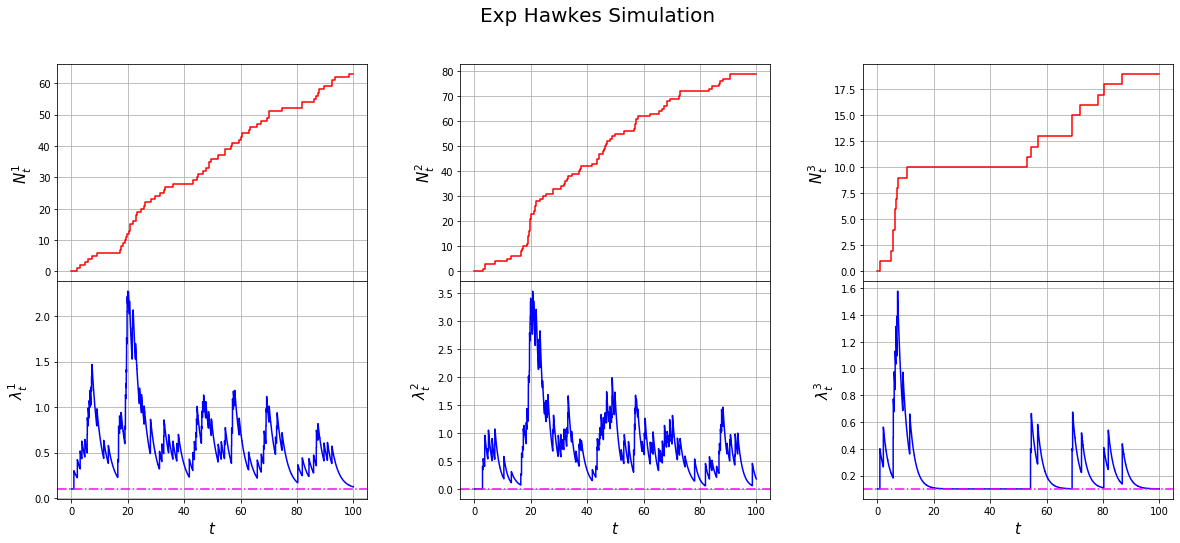

In [8]:
## Simulate!
r.seed(0)
arrivals = simulate_mlt_hawkes(params_org, t_max)
Hawkes_plot(arrivals, params_org, t_max, delta)
plt.savefig("3-dim_simulation.eps")

# Monte Carlo Simulation

In [9]:
## Parameters
mu = np.array([0.1, 0., 0.1])
alpha = np.array([
    [0., 0.2, 0.2],
    [0.4, 0.2, 0.],
    [0., 0., 0.3],
    ])
beta = np.array([
    [1., 0.4, 0.4],
    [0.7, 0.4, 1.],
    [1., 1., 0.5],
    ])
x = np.array([0, 0, 0])

params_org = list([mu, alpha, beta, x])

## alpha/betaのスペクトル半径，1以下でないと発散
print("Spectral radius", end=": ")
print(max(abs(LA.eig(alpha/beta)[0])))

## End time
t_max = 1000

Spectral radius: 0.8400968443520824


In [10]:
## optimの設定 : optimを使うためには１次元配列で渡さなくてはならない．悲しみ．
params = mu.reshape(1, -1).tolist()[0]
params[len(params):len(params)] = alpha.reshape(1, -1).tolist()[0]
params[len(params):len(params)] = beta.reshape(1, -1).tolist()[0]
dim = int((np.sqrt(8*len(params)+1)-1)/4)
params_num = dim+2*dim**2
pd.DataFrame(params).to_csv("true_params_for_3d_simu.csv")

In [11]:
#探索範囲
low_bd = [0]*(dim)
low_bd[len(low_bd):len(low_bd)] = [0]*(dim**2)
low_bd[len(low_bd):len(low_bd)] = [1.e-5]*(dim**2)
up_bd = [1.e+4]*params_num
bounds = optimize.Bounds(low_bd, up_bd)
#推定回数
M = 300

## Create Sample Data

In [12]:
r.seed(0)
arrivals = []
for i in tqdm(range(M)):
    arrivals.append(simulate_mlt_hawkes(params_org, t_max))

## QMLE

In [13]:
## MLEをM個格納する入れ物
mu_list_QMLE = []
alpha_list_QMLE = []
beta_list_QMLE = []

## MLEをM回計算
for i in tqdm(range(M)):
    res = optimize.minimize(fun=loglik, x0=np.array(params), args=arrivals[i], method='L-BFGS-B', bounds=bounds)
    mle = result_show(res, round=8, result_show = False)
    mu_list_QMLE.append((np.sqrt(t_max)*(mle[0]-mu)).tolist())
    alpha_list_QMLE.append((np.sqrt(t_max)*(mle[1]-alpha)).tolist())
    beta_list_QMLE.append((np.sqrt(t_max)*(mle[2]-beta)).tolist())

Histogram.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instanc

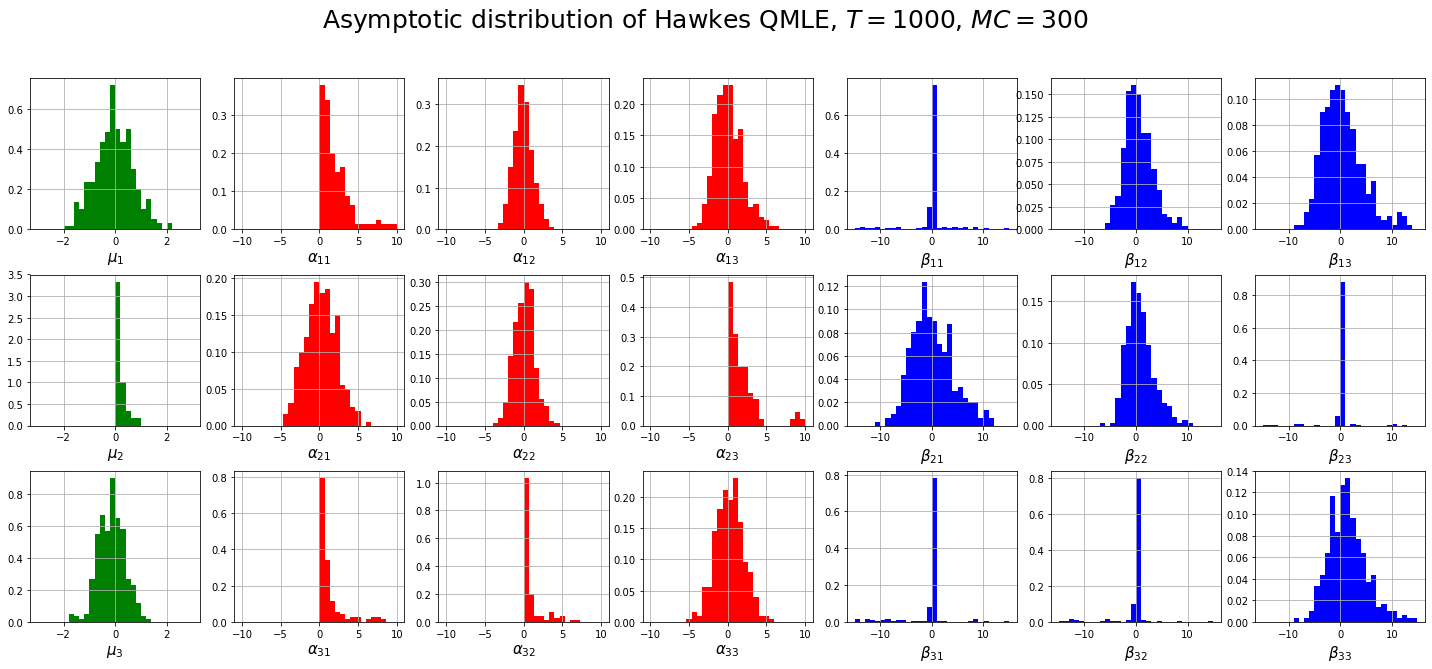

In [14]:
fig = plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
gs = gridspec.GridSpec(dim, 1+2*dim)

for i in range(dim):
    ax = fig.add_subplot(gs[i,0])
    plt.subplot(gs[i,0])
    a = np.array([x[i] for x in mu_list_QMLE])
    sd = np.sqrt(np.var(a[a!=0]))
    ax.hist(a[a!=0],range=(-3, 3), bins=30, density=True, color="green")
    plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=15)
    ax.grid()

for i in range(dim):
    for j in range(dim):
        ax = fig.add_subplot(gs[i,j+1])
        plt.subplot(gs[i,j+1])
        a = np.array([x[i][j] for x in alpha_list_QMLE])
        sd = np.sqrt(np.var(a))
        ax.hist(a[a!=0], range=(-10, 10), bins=30, density=True, color="red")
        plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)), fontsize=15)
        ax.grid()
        
for i in range(dim):
    for j in range(dim):            
        ax = fig.add_subplot(gs[i,j+1+dim])
        plt.subplot(gs[i,j+1+dim])
        a = np.array([x[i][j] for x in beta_list_QMLE])
        sd = np.sqrt(np.var(a))
        ax.hist(a, range=(-15, 15), bins=30, density=True, color="blue")
        plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=15)
        ax.grid()
        

fig.suptitle('Asymptotic distribution of Hawkes QMLE, $T=%d$, $MC=%d$' %(t_max, M), fontsize=25)
plt.savefig("asymp_QMLE_T={}.eps".format(t_max))
plt.show()

Number of parameters estimated to be zero.

In [15]:
for i in range(dim):
    cnt = 0
    for n in range(M):
        if (mu_list_QMLE[n][i]/np.sqrt(t_max) + mu[i] ==0):
            cnt = cnt +1        
    print(r'mu_{%d}' %(i+1), end=": ")
    print(cnt)

for i in range(dim):
    for j in range(dim):
        cnt = 0
        for n in range(M):
            if (alpha_list_QMLE[n][i][j]/np.sqrt(t_max) + alpha[i][j] ==0):
                cnt = cnt +1
        print(r'alpha_{%d%d}' %((i+1), (j+1)), end=": ")
        print(cnt)

mu_{1}: 0
mu_{2}: 270
mu_{3}: 0
alpha_{11}: 176
alpha_{12}: 0
alpha_{13}: 0
alpha_{21}: 0
alpha_{22}: 0
alpha_{23}: 227
alpha_{31}: 189
alpha_{32}: 189
alpha_{33}: 0


## LASSO, LASSO + QMLE

In [16]:
# given paramをstrで与えておく
def param_gene(params):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    dim = len(mu)

    given=[[],[],[]]
    mu_id = []
    alpha_id =[]
    beta_id = []
    
    for i in range(dim):
        if type(mu[i]) == str:
            given[0].append([i+1, float(mu[i])])
            mu_id.append(i)
            
    for i in range(dim):
        for j in range(dim):
            if type(alpha[i][j]) == str:
                given[1].append([i+1, j+1, float(alpha[i][j])])
                alpha_id.append(i*dim+j)
            if type(beta[i][j]) == str:
                given[2].append([i+1, j+1, float(beta[i][j])])
                beta_id.append(i*dim+j)

    mu = np.delete(mu, mu_id)
    alpha = list(map(lambda a: float(a), itertools.chain.from_iterable(alpha)))
    alpha = np.delete(alpha, alpha_id)
    beta = list(map(lambda b: float(b), itertools.chain.from_iterable(beta)))
    beta = np.delete(beta, beta_id)
   
    cparams = mu
    cparams = np.append(cparams, alpha)
    cparams = np.append(cparams, beta)
    return cparams, given

def re_params(cparams, given, dim):
    for i in range(3):
        if given[i]==[]:
            continue
        for cns in sorted(given[i]):
            if i==0:
                cparams = np.insert(cparams, cns[0]-1, cns[-1])
            elif i==1:
                cparams = np.insert(cparams, dim+dim*(cns[0]-1)+(cns[1]-1), cns[-1])
            else:
                cparams = np.insert(cparams, dim+dim**2+dim*(cns[0]-1)+(cns[1]-1), cns[-1])
    return cparams

# given = [[[1,2]],[[1,2,0.1]],[[1,2,1], [2,2,0.5]]]
# mu_1=2, alpha_{12}=0.1, beta_{12}=1, beta_{22}=0.5
# arg = [arrivals, dim, given]
def cloglik(cparams, arg):
    arrivals = arg[0]
    dim = arg[1]
    given = arg[2]
    cparams = re_params(cparams, given, dim)
    return loglik(cparams, arrivals)

In [ ]:
dim = 3
mu_list_LASSO = []
alpha_list_LASSO = []
beta_list_LASSO = []
mu_list_LASSO_QMLE = []
alpha_list_LASSO_QMLE = []
beta_list_LASSO_QMLE = []

#探索範囲
low_bd = [0]*(dim)
low_bd[len(low_bd):len(low_bd)] = [0]*(dim**2)
low_bd[len(low_bd):len(low_bd)] = [1.e-5]*(dim**2)
up_bd = [1.e+4]*params_num
bounds = optimize.Bounds(low_bd, up_bd)
#推定回数
M = 300

for n in tqdm(range(M)):
    # LASSO
    res = optimize.minimize(fun=Lasso_loglik, x0=np.array(params), args=arrivals[n], method='L-BFGS-B', bounds=bounds)
    LASSO = result_show(res, round=8, result_show = False)
    mu_list_LASSO.append((np.sqrt(t_max)*(LASSO[0]-mu)).tolist())
    alpha_list_LASSO.append((np.sqrt(t_max)*(LASSO[1]-alpha)).tolist())
    beta_list_LASSO.append((np.sqrt(t_max)*(LASSO[2]-beta)).tolist())
    
    # LASSO + QMLE
    new_mu = LASSO[0].tolist()
    new_alpha = LASSO[1].tolist()
    new_beta = LASSO[2].tolist()
    for i in range(dim):
        if new_mu[i]==0.:
            new_mu[i]='0.'
    for i in range(dim):
        for j in range(dim):
            if new_alpha[i][j]==0.:
                new_alpha[i][j]='0.'
                new_beta[i][j]='1.'
    new_params = [new_mu, new_alpha, new_beta]
    cparams, given = param_gene(new_params)
    
    #探索範囲
    new_params_num = len(cparams)
    new_beta_num = dim**2-len(given[2])
    low_bd_new = [0]*(new_params_num-new_beta_num)
    low_bd_new[len(low_bd_new):len(low_bd_new)] = [1.e-5]*(new_beta_num)
    up_bd_new = [1.e+4]*new_params_num
    bounds_new = optimize.Bounds(low_bd_new, up_bd_new)
    
    res_LASSO_QMLE = optimize.minimize(fun=cloglik, x0=np.array(cparams, dtype=float), args=[arrivals[n], dim, given], method='L-BFGS-B', bounds=bounds_new)
    p = re_params(res_LASSO_QMLE.x, given, dim)
    mu_list_LASSO_QMLE.append((np.sqrt(t_max)*(np.array(p[:dim])-mu)).tolist())
    alpha_list_LASSO_QMLE.append((np.sqrt(t_max)*(np.array(p[dim:(dim+dim**2)]).reshape((dim, dim))-alpha)).tolist())
    beta_list_LASSO_QMLE.append((np.sqrt(t_max)*(np.array(p[(dim+dim**2):]).reshape((dim, dim))-beta)).tolist())

### Results for LASSO

In [ ]:
for i in range(dim):
    cnt = 0
    for n in range(M):
        if (mu_list_LASSO[n][i]/np.sqrt(t_max) + mu[i] ==0):
            cnt = cnt +1        
    print(r'mu_{%d}' %(i+1), end=": ")
    print(cnt)

for i in range(dim):
    for j in range(dim):
        cnt = 0
        for n in range(M):
            if (alpha_list_LASSO[n][i][j]/np.sqrt(t_max) + alpha[i][j] ==0):
                cnt = cnt +1
        print(r'alpha_{%d%d}' %((i+1), (j+1)), end=": ")
        print(cnt)

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
gs = gridspec.GridSpec(dim, 1+2*dim)

for i in range(dim):
    ax = fig.add_subplot(gs[i,0])
    plt.subplot(gs[i,0])
    a = np.array([x[i] for x in mu_list_LASSO])
    ax.hist(a[a!=0], range=(-3, 3), bins=35, normed=True, rwidth=1, color="green")
    plt.xlabel(r'$ \mu_{%d} $' %(i+1))
    ax.grid()

for i in range(dim):
    for j in range(dim):
        ax = fig.add_subplot(gs[i,j+1])
        plt.subplot(gs[i,j+1])
        a = np.array([x[i][j] for x in alpha_list_LASSO])
        ax.hist(a[a!=0], range=(-10, 10), bins=35, normed=True, rwidth=1, color="red")
        plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)))
        ax.grid()
        
for i in range(dim):
    for j in range(dim):            
        ax = fig.add_subplot(gs[i,j+1+dim])
        plt.subplot(gs[i,j+1+dim])
        a = np.array([x[i][j] for x in beta_list_LASSO])
        ax.hist(a, range=(-15, 15), bins=35, normed=True, rwidth=1, color="blue")
        plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)))
        ax.grid()

fig.suptitle('Asymptotic distribution of Hawkes LASSO, $T=%d$, $MC=%d$' %(t_max, M), fontsize=25)
plt.savefig("asymp_LASSO_T={}.eps".format(t_max))
plt.show()

### Results for LASSO+QMLE

In [ ]:
for i in range(dim):
    cnt = 0
    for n in range(M):
        if (mu_list_LASSO_QMLE[n][i]/np.sqrt(t_max) + mu[i] ==0):
            cnt = cnt +1        
    print(r'mu_{%d}' %(i+1), end=": ")
    print(cnt)

for i in range(dim):
    for j in range(dim):
        cnt = 0
        for n in range(M):
            if (alpha_list_LASSO_QMLE[n][i][j]/np.sqrt(t_max) + alpha[i][j] ==0):
                cnt = cnt +1
        print(r'alpha_{%d%d}' %((i+1), (j+1)), end=": ")
        print(cnt)

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
gs = gridspec.GridSpec(dim, 1+2*dim)

for i in range(dim):
    ax = fig.add_subplot(gs[i,0])
    plt.subplot(gs[i,0])
    a = np.array([x[i] for x in mu_list_LASSO_QMLE])
    sd = np.sqrt(np.var(a[a!=0]))
    if np.sum(a!=0)>0: ax.hist(a[a!=0], range=(-sd*5, sd*5), bins=35, normed=True, rwidth=1, color="green")
    plt.xlabel(r'$ \mu_{%d} $' %(i+1))
    ax.grid()

for i in range(dim):
    for j in range(dim):
        ax = fig.add_subplot(gs[i,j+1])
        plt.subplot(gs[i,j+1])
        a = np.array([x[i][j] for x in alpha_list_LASSO_QMLE])
        if np.sum(a!=0)>0: ax.hist(a[a!=0], range=(-10, 10), bins=35, normed=True, rwidth=1, color="red")
        plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)))
        ax.grid()
        
for i in range(dim):
    for j in range(dim):            
        ax = fig.add_subplot(gs[i,j+1+dim])
        plt.subplot(gs[i,j+1+dim])
        a = np.array([x[i][j] for x in beta_list_LASSO_QMLE])
        ax.hist(a, range=(-15, 15), bins=35, normed=True, rwidth=1, color="blue")
        plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)))
        ax.grid()
        

fig.suptitle('Asymptotic distribution of Hawkes LASSO + QMLE, $T=%d$, $MC=%d$' %(t_max, M), fontsize=25)
plt.savefig("asymp_QMLE_2nd_T={}.eps".format(t_max))
plt.show()

## LASSO with large β

In [ ]:
dim = 3
mu_list_LASSO_2 = []
alpha_list_LASSO_2 = []
beta_list_LASSO_2 = []

## Parameters
beta_2 = np.array([
    [100., 0.4, 0.4],
    [0.7, 0.4, 100.],
    [100., 100., 0.5],
    ])
params_2 = mu.reshape(1, -1).tolist()[0]
params_2[len(params_2):len(params_2)] = alpha.reshape(1, -1).tolist()[0]
params_2[len(params_2):len(params_2)] = beta_2.reshape(1, -1).tolist()[0]

#探索範囲
low_bd = [0]*(dim)
low_bd[len(low_bd):len(low_bd)] = [0]*(dim**2)
low_bd[len(low_bd):len(low_bd)] = [1.e-5]*(dim**2)
up_bd = [1.e+4]*params_num
bounds = optimize.Bounds(low_bd, up_bd)
#推定回数
M = 300

for i in tqdm(range(M)):
    # LASSO
    res = optimize.minimize(fun=Lasso_loglik, x0=np.array(params_2), args=arrivals[i], method='L-BFGS-B', bounds=bounds)
    LASSO = result_show(res, round=8, result_show = False)
    mu_list_LASSO_2.append((np.sqrt(t_max)*(LASSO[0]-mu)).tolist())
    alpha_list_LASSO_2.append((np.sqrt(t_max)*(LASSO[1]-alpha)).tolist())
    beta_list_LASSO_2.append((np.sqrt(t_max)*(LASSO[2]-beta_2)).tolist())

In [ ]:
for i in range(dim):
    cnt = 0
    for n in range(M):
        if (mu_list_LASSO_2[n][i]/np.sqrt(t_max) + mu[i] ==0):
            cnt = cnt +1        
    print(r'mu_{%d}' %(i+1), end=": ")
    print(cnt)

for i in range(dim):
    for j in range(dim):
        cnt = 0
        for n in range(M):
            if (alpha_list_LASSO_2[n][i][j]/np.sqrt(t_max) + alpha[i][j] ==0):
                cnt = cnt +1
        print(r'alpha_{%d%d}' %((i+1), (j+1)), end=": ")
        print(cnt)

# Case : T = 100
## Create data

In [ ]:
## Parameters
mu = np.array([0.1, 0., 0.1])
alpha = np.array([
    [0., 0.2, 0.2],
    [0.4, 0.2, 0.],
    [0., 0., 0.3],
    ])
beta = np.array([
    [1., 0.4, 0.4],
    [0.7, 0.4, 1.],
    [1., 1., 0.5],
    ])
x = np.array([0, 0, 0])

params_org = list([mu, alpha, beta, x])

## End time
t_max = 100

In [ ]:
r.seed(0)
arrivals_100 = []
for i in tqdm(range(M)):
    arrivals_100.append(simulate_mlt_hawkes(params_org, t_max))

## QMLE

In [ ]:
## MLEをM個格納する入れ物
mu_list_QMLE_100 = []
alpha_list_QMLE_100 = []
beta_list_QMLE_100 = []

## MLEをM回計算
for i in tqdm(range(M)):
    res = optimize.minimize(fun=loglik, x0=np.array(params), args=arrivals_100[i], method='L-BFGS-B', bounds=bounds)
    mle = result_show(res, round=8, result_show = False)
    mu_list_QMLE_100.append((np.sqrt(t_max)*(mle[0]-mu)).tolist())
    alpha_list_QMLE_100.append((np.sqrt(t_max)*(mle[1]-alpha)).tolist())
    beta_list_QMLE_100.append((np.sqrt(t_max)*(mle[2]-beta)).tolist())

In [ ]:
t_max=100
fig = plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
gs = gridspec.GridSpec(dim, 1+2*dim)

for i in range(dim):
    ax = fig.add_subplot(gs[i,0])
    plt.subplot(gs[i,0])
    a = np.array([x[i] for x in mu_list_QMLE_100])
    ax.hist(a[a!=0],range=(-3, 3), bins=30, density=True, color="green")
    plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=15)
    ax.grid()

for i in range(dim):
    for j in range(dim):
        ax = fig.add_subplot(gs[i,j+1])
        plt.subplot(gs[i,j+1])
        a = np.array([x[i][j] for x in alpha_list_QMLE_100])
        ax.hist(a[a!=0], range=(-10, 10), bins=30, density=True, color="red")
        plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)), fontsize=15)
        ax.grid()
        
for i in range(dim):
    for j in range(dim):            
        ax = fig.add_subplot(gs[i,j+1+dim])
        plt.subplot(gs[i,j+1+dim])
        a = np.array([x[i][j] for x in beta_list_QMLE_100])
        ax.hist(a, range=(-15, 15), bins=30, density=True, color="blue")
        plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=15)
        ax.grid()
        

fig.suptitle('Asymptotic distribution of Hawkes QMLE, $T=%d$, $MC=%d$' %(t_max, M), fontsize=25)
plt.savefig("asymp_QMLE_T={}.eps".format(t_max))
plt.show()